# Introduction to Supervised ML- Linear and Logistic Regression

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error, classification_report, confusion_matrix

In [2]:
# Mount GDrive's folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This code imports a library "os" that allows file navigation
import os
# This code sets the home directory
# Find your folder and put the path here as a string
os.chdir('/content/drive/MyDrive/my_workspace')

**Objective:**

Test if a customer's spending on certain categories for past 3 quarters can predict the total spending in the current quarter

Lets set current quarter as 2021 Q3 (the latest complete quarter in the dataset).

## Read the dataset

In [30]:
df = pd.read_csv("Data/cc_clean.csv")
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 13:53:31
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 13:29:28
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 13:52:37
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 12:33:50


In [31]:
# Convert to pandas datetimes
df['trans_datetime'] = pd.to_datetime(df['trans_datetime'])
# Convert acct_num to int
df['acct_num'] = df['acct_num'].astype(int)
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,798000000000,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 13:53:31
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,968000000000,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 13:29:28
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,628000000000,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 13:52:37
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,540000000000,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 12:33:50


In [70]:
combined = pd.read_csv("Data/combined_df.csv")
combined.head()

,acct_num,recency,recency_score,frequency,frequency_score,total_amt,monetary_score,rfm_score,rfm_level,cluster
0,1.240000e+11,24,3,931,3,66457.92,3,9,Top,0
1,1.690000e+11,141,1,9,1,2814.60,1,3,Low,1
2,1.700000e+11,24,3,890,3,64448.85,3,9,Top,0
3,2.010000e+11,25,3,306,2,24489.46,2,7,Top,2
4,2.038000e+11,111,1,12,1,8803.87,1,3,Low,1


## Prepare the data

1. Filter to only selected categories

In [32]:
selected_categories = ['shopping_net','gas_transport','health_fitness']

In [34]:
# filter by category
 # add code here
df = df[df['category'].isin(selected_categories)]

2. Filter to inclusive dates

In [35]:
start_date = pd.to_datetime('2020-10-01')
end_date = pd.to_datetime('2021-09-30')
df = df[(df['trans_datetime'] >= start_date) & (df['trans_datetime'] <= end_date)]
df['trans_datetime'].min(),df['trans_datetime'].max()

(Timestamp('2020-10-01 00:12:36'), Timestamp('2021-09-29 18:01:24'))

3. Get quarterly total spending per category for each customer

In [36]:
df['quarter'] = df['trans_datetime'].dt.to_period('Q').astype(str)
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime,quarter
19,5.200000e+15,M,Palayan City,41041,Emergency planning/management officer,19/09/1960,420000000000,420000000000,d95afc116a4880fa64aa63f2fd8d01a3,1618616554,health_fitness,67.45,2021-04-17 07:42:34,2021Q2
22,1.800000e+14,M,San Fernando,306659,"Engineer, mining",09/11/1930,939000000000,939000000000,dbae67fe8c9b43fc0d4422aeae8d04e4,1632118274,shopping_net,5.86,2021-09-20 14:11:14,2021Q3
54,3.590000e+15,M,Masbate,95389,Brewing technologist,23/06/1955,170000000000,170000000000,3e6f98cc983f19e0f5c90b93567ce77d,1607899248,health_fitness,8.29,2020-12-14 06:40:48,2020Q4
59,5.700000e+11,M,Makati City,582602,"Surveyor, planning and development",26/07/1957,902100000000,902000000000,c7e08fd70e42a00c05a008ae5931d763,1611021260,gas_transport,74.92,2021-01-19 09:54:20,2021Q1
60,4.010000e+12,M,Malaybalay,174625,Tourist information centre manager,11/01/1966,439000000000,439000000000,c53d9238ce489cae66a09ca1e08f483b,1630138105,shopping_net,4.49,2021-08-28 16:08:25,2021Q3


In [37]:
total_df = df.groupby(['acct_num','quarter'])['amt'].sum().to_frame(name="total_amt").reset_index()
total_df = total_df[total_df['quarter']=='2021Q3']
total_df = total_df.set_index('acct_num')
total_df = total_df.drop(columns = "quarter")
total_df

,total_amt
acct_num,
124000000000,5047.03
169000000000,973.86
170000000000,2938.04
201000000000,1977.81
203800000000,3007.53
...,...
969000000000,276.42
971000000000,3072.88
989000000000,927.68


4. Get total spending for selected categories for quarters=`['2020Q3','2021Q1','2021Q2']` for each customer



In [38]:
cutoff_date = pd.to_datetime('2021-06-30')
data = df[df['trans_datetime']<=cutoff_date]

In [39]:
category_df = data.groupby(['acct_num','category','quarter'])['amt'].agg(['count','sum'])
category_df = category_df.reset_index()
category_df = category_df.rename(columns={'sum':'total'})
category_df

,acct_num,category,quarter,count,total
0,124000000000,gas_transport,2020Q4,28,1892.85
1,124000000000,gas_transport,2021Q1,26,1782.17
2,124000000000,gas_transport,2021Q2,22,1422.27
3,124000000000,health_fitness,2020Q4,21,682.68
4,124000000000,health_fitness,2021Q1,9,159.89
...,...,...,...,...,...
643,996400000000,health_fitness,2021Q1,14,328.52
644,996400000000,health_fitness,2021Q2,11,542.23
645,996400000000,shopping_net,2020Q4,10,113.08
646,996400000000,shopping_net,2021Q1,10,379.26


5. Reshape table so each category has its own column

In [40]:
pivot_category_df = category_df.pivot(index='acct_num', columns=['category','quarter'], values=['count','total']).fillna(0)
pivot_category_df

count                                             \
category     gas_transport               health_fitness                 
quarter             2020Q4 2021Q1 2021Q2         2020Q4 2021Q1 2021Q2   
acct_num                                                                
124000000000          28.0   26.0   22.0           21.0    9.0   13.0   
138000000000           1.0    0.0    0.0            0.0    0.0    0.0   
170000000000          18.0   21.0   23.0           14.0    6.0   11.0   
201000000000          12.0    7.0   10.0            7.0    4.0    7.0   
207000000000          23.0   24.0   27.0           12.0   11.0   12.0   
...                    ...    ...    ...            ...    ...    ...   
969000000000           6.0    9.0    5.0            6.0    4.0    9.0   
971000000000          30.0   24.0   22.0           12.0   10.0   15.0   
989000000000          11.0    4.0    6.0           10.0    6.0    2.0   
994000000000          18.0    9.0   16.0           19.0    7.0   15.0   
996400000000          36.0   16.0   15.0           13.0   14.0   11.0   

                                                total                    \
category     shopping_net               gas_transport                     
quarter            2020Q4 2021Q1 2021Q2        2020Q4   2021Q1   2021Q2   
acct_num                                                                  
124000000000         20.0    7.0   13.0       1892.85  1782.17  1422.27   
138000000000          2.0    0.0    0.0          8.55     0.00     0.00   
170000000000         10.0   10.0   14.0       1163.94  1623.23  1523.51   
201000000000          7.0    5.0    5.0        806.26   517.82   681.10   
207000000000         16.0   11.0   16.0       1578.15  1586.24  1853.35   
...                   ...    ...    ...           ...      ...      ...   
969000000000          2.0    0.0    5.0        371.03   677.96   353.01   
971000000000         12.0    7.0   15.0       2151.55  1558.58  1351.40   
989000000000          7.0    3.0    4.0        757.09   296.78   402.59   
994000000000         10.0    4.0    6.0       1329.75   670.67  1078.94   
996400000000         10.0   10.0   12.0       2461.25  1038.68  1003.90   

                                                                            
category     health_fitness                 shopping_net                    
quarter              2020Q4  2021Q1  2021Q2       2020Q4   2021Q1   2021Q2  
acct_num                                                                    
124000000000         682.68  159.89  799.40      1412.22  1603.53  1304.40  
138000000000           0.00    0.00    0.00      2035.87     0.00     0.00  
170000000000         728.24  201.64  285.22       841.51  1163.28   330.39  
201000000000         497.72  166.93  185.30       751.89   372.53  3792.19  
207000000000         835.50  244.07  626.33       978.29   602.60  1459.86  
...                     ...     ...     ...          ...      ...      ...  
969000000000         430.19   14.31  329.75        38.77     0.00   116.20  
971000000000         605.65  168.19  680.23      1192.04   342.70  6127.19  
989000000000         797.62  117.97   43.31        66.75   202.08  1174.07  
994000000000         946.77  119.35  766.52      1119.43    22.77   343.39  
996400000000         839.18  328.52  542.23       113.08   379.26  2333.07  

[80 rows x 18 columns]

In [41]:
#flatten columns
pivot_category_df.columns = ['_'.join(col) for col in pivot_category_df.columns]
pivot_category_df

,count_gas_transport_2020Q4,count_gas_transport_2021Q1,count_gas_transport_2021Q2,count_health_fitness_2020Q4,count_health_fitness_2021Q1,count_health_fitness_2021Q2,count_shopping_net_2020Q4,count_shopping_net_2021Q1,count_shopping_net_2021Q2,total_gas_transport_2020Q4,total_gas_transport_2021Q1,total_gas_transport_2021Q2,total_health_fitness_2020Q4,total_health_fitness_2021Q1,total_health_fitness_2021Q2,total_shopping_net_2020Q4,total_shopping_net_2021Q1,total_shopping_net_2021Q2
acct_num,,,,,,,,,,,,,,,,,,
124000000000,28.0,26.0,22.0,21.0,9.0,13.0,20.0,7.0,13.0,1892.85,1782.17,1422.27,682.68,159.89,799.40,1412.22,1603.53,1304.40
138000000000,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,8.55,0.00,0.00,0.00,0.00,0.00,2035.87,0.00,0.00
170000000000,18.0,21.0,23.0,14.0,6.0,11.0,10.0,10.0,14.0,1163.94,1623.23,1523.51,728.24,201.64,285.22,841.51,1163.28,330.39
201000000000,12.0,7.0,10.0,7.0,4.0,7.0,7.0,5.0,5.0,806.26,517.82,681.10,497.72,166.93,185.30,751.89,372.53,3792.19
207000000000,23.0,24.0,27.0,12.0,11.0,12.0,16.0,11.0,16.0,1578.15,1586.24,1853.35,835.50,244.07,626.33,978.29,602.60,1459.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969000000000,6.0,9.0,5.0,6.0,4.0,9.0,2.0,0.0,5.0,371.03,677.96,353.01,430.19,14.31,329.75,38.77,0.00,116.20
971000000000,30.0,24.0,22.0,12.0,10.0,15.0,12.0,7.0,15.0,2151.55,1558.58,1351.40,605.65,168.19,680.23,1192.04,342.70,6127.19
989000000000,11.0,4.0,6.0,10.0,6.0,2.0,7.0,3.0,4.0,757.09,296.78,402.59,797.62,117.97,43.31,66.75,202.08,1174.07


6. Join total spending table with total spending per category table

In [42]:
print(len(total_df), len(pivot_category_df))
# use join instead of merge if you have used a non-default index
total_df = total_df.join(pivot_category_df, how='inner')
print(len(total_df))
total_df.head()

79 80
71


,total_amt,count_gas_transport_2020Q4,count_gas_transport_2021Q1,count_gas_transport_2021Q2,count_health_fitness_2020Q4,count_health_fitness_2021Q1,count_health_fitness_2021Q2,count_shopping_net_2020Q4,count_shopping_net_2021Q1,count_shopping_net_2021Q2,total_gas_transport_2020Q4,total_gas_transport_2021Q1,total_gas_transport_2021Q2,total_health_fitness_2020Q4,total_health_fitness_2021Q1,total_health_fitness_2021Q2,total_shopping_net_2020Q4,total_shopping_net_2021Q1,total_shopping_net_2021Q2
acct_num,,,,,,,,,,,,,,,,,,,
124000000000,5047.03,28.0,26.0,22.0,21.0,9.0,13.0,20.0,7.0,13.0,1892.85,1782.17,1422.27,682.68,159.89,799.40,1412.22,1603.53,1304.40
170000000000,2938.04,18.0,21.0,23.0,14.0,6.0,11.0,10.0,10.0,14.0,1163.94,1623.23,1523.51,728.24,201.64,285.22,841.51,1163.28,330.39
201000000000,1977.81,12.0,7.0,10.0,7.0,4.0,7.0,7.0,5.0,5.0,806.26,517.82,681.10,497.72,166.93,185.30,751.89,372.53,3792.19
207000000000,2993.02,23.0,24.0,27.0,12.0,11.0,12.0,16.0,11.0,16.0,1578.15,1586.24,1853.35,835.50,244.07,626.33,978.29,602.60,1459.86
208000000000,608.44,9.0,6.0,8.0,8.0,1.0,4.0,6.0,2.0,6.0,663.38,404.09,575.70,286.01,5.63,113.66,150.09,498.19,4179.89


array([[<Axes: title={'center': 'total_amt'}>,
        <Axes: title={'center': 'count_gas_transport_2020Q4'}>,
        <Axes: title={'center': 'count_gas_transport_2021Q1'}>,
        <Axes: title={'center': 'count_gas_transport_2021Q2'}>],
       [<Axes: title={'center': 'count_health_fitness_2020Q4'}>,
        <Axes: title={'center': 'count_health_fitness_2021Q1'}>,
        <Axes: title={'center': 'count_health_fitness_2021Q2'}>,
        <Axes: title={'center': 'count_shopping_net_2020Q4'}>],
       [<Axes: title={'center': 'count_shopping_net_2021Q1'}>,
        <Axes: title={'center': 'count_shopping_net_2021Q2'}>,
        <Axes: title={'center': 'total_gas_transport_2020Q4'}>,
        <Axes: title={'center': 'total_gas_transport_2021Q1'}>],
       [<Axes: title={'center': 'total_gas_transport_2021Q2'}>,
        <Axes: title={'center': 'total_health_fitness_2020Q4'}>,
        <Axes: title={'center': 'total_health_fitness_2021Q1'}>,
        <Axes: title={'center': 'total_health_fitnes

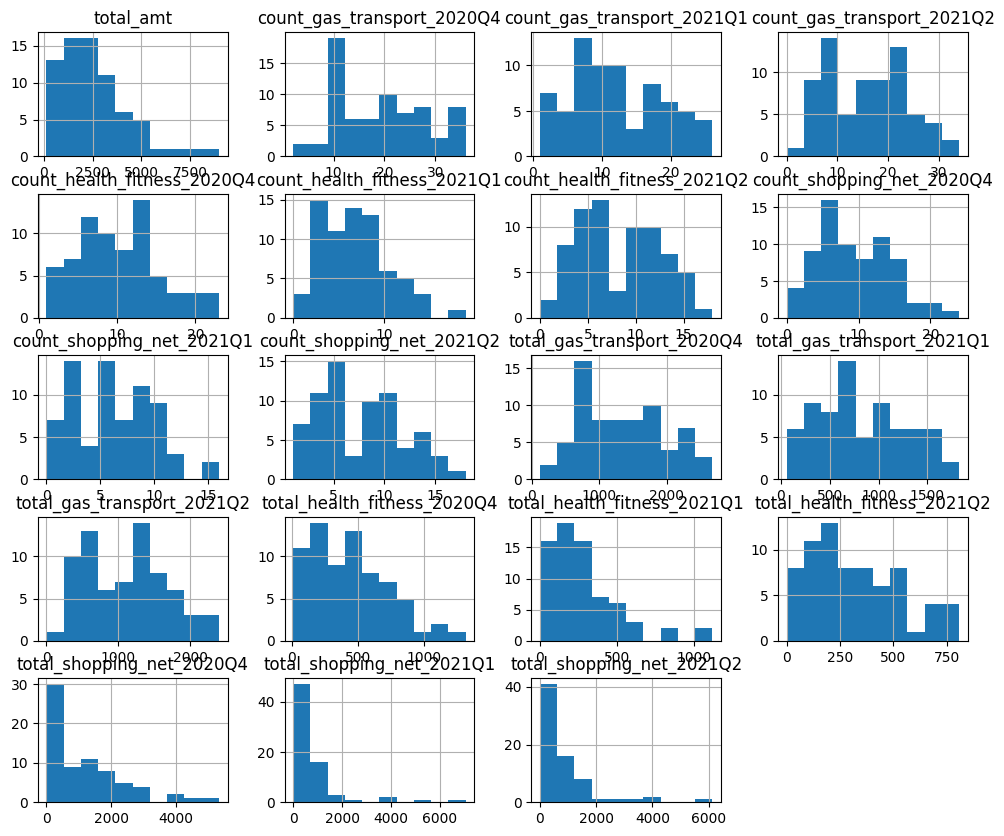

In [43]:
total_df.hist(figsize=(12,10))

## 1. Predict using Linear Regression

> Can we predict the total spending amount for 2021Q3 given spending from selected categories?


In [45]:
total_df.columns


Index(['total_amt', 'count_gas_transport_2020Q4', 'count_gas_transport_2021Q1',
       'count_gas_transport_2021Q2', 'count_health_fitness_2020Q4',
       'count_health_fitness_2021Q1', 'count_health_fitness_2021Q2',
       'count_shopping_net_2020Q4', 'count_shopping_net_2021Q1',
       'count_shopping_net_2021Q2', 'total_gas_transport_2020Q4',
       'total_gas_transport_2021Q1', 'total_gas_transport_2021Q2',
       'total_health_fitness_2020Q4', 'total_health_fitness_2021Q1',
       'total_health_fitness_2021Q2', 'total_shopping_net_2020Q4',
       'total_shopping_net_2021Q1', 'total_shopping_net_2021Q2'],
      dtype='object')

In [46]:
# Declare columns to use as features (input)
feature_cols = ['count_gas_transport_2020Q4', 'count_gas_transport_2021Q1',
       'count_gas_transport_2021Q2', 'count_health_fitness_2020Q4',
       'count_health_fitness_2021Q1', 'count_health_fitness_2021Q2',
       'count_shopping_net_2020Q4', 'count_shopping_net_2021Q1',
       'count_shopping_net_2021Q2', 'total_gas_transport_2020Q4',
       'total_gas_transport_2021Q1', 'total_gas_transport_2021Q2',
       'total_health_fitness_2020Q4', 'total_health_fitness_2021Q1',
       'total_health_fitness_2021Q2', 'total_shopping_net_2020Q4',
       'total_shopping_net_2021Q1', 'total_shopping_net_2021Q2']

In [47]:
# Declare input and target variables
X = total_df[feature_cols]
y = total_df['total_amt']

In [48]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [49]:
len(X_train), len(X_test), len(y_train), len(y_test)

(49, 22, 49, 22)

In [50]:
# Initialize model
model = LinearRegression()

In [51]:
# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [52]:
# Predict on the test data
y_pred = model.predict(X_test)

In [53]:
# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.2f}')

R-squared: 0.48


In [54]:
# Helper function to calculate errors
def calculate_errors(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
  return rmse, mae, mape

In [55]:
# Evaluate the model's performance
rmse, mae, mape = calculate_errors(y_test, y_pred)
print(f'Root Mean Square Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}')

Root Mean Square Error: 1415.46
Mean Absolute Error: 1018.08
Mean Absolute Percentage Error: 67.69


In [56]:
# View the slopes (coefficients) for each feature
coefficients = model.coef_
print("Slopes (coefficients) for each feature:")
for i, coef in enumerate(coefficients):
    print(f"Feature {feature_cols[i]}: {coef:.4f}")

Slopes (coefficients) for each feature:
Feature count_gas_transport_2020Q4: -195.9267
Feature count_gas_transport_2021Q1: -480.2568
Feature count_gas_transport_2021Q2: -101.7464
Feature count_health_fitness_2020Q4: 45.9867
Feature count_health_fitness_2021Q1: 57.6215
Feature count_health_fitness_2021Q2: -9.6790
Feature count_shopping_net_2020Q4: -56.6301
Feature count_shopping_net_2021Q1: -37.0323
Feature count_shopping_net_2021Q2: 122.7185
Feature total_gas_transport_2020Q4: 3.8263
Feature total_gas_transport_2021Q1: 6.5633
Feature total_gas_transport_2021Q2: 1.8011
Feature total_health_fitness_2020Q4: -1.2586
Feature total_health_fitness_2021Q1: 0.7965
Feature total_health_fitness_2021Q2: 3.5686
Feature total_shopping_net_2020Q4: -0.1596
Feature total_shopping_net_2021Q1: -0.0603
Feature total_shopping_net_2021Q2: -0.0111


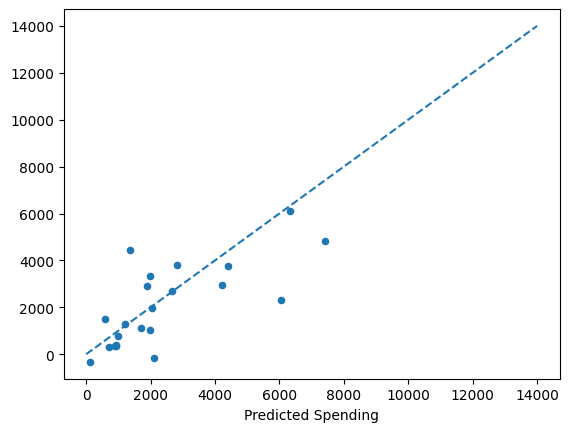

In [58]:
import matplotlib.pyplot as plt

# plot actual and predicted
plt.scatter(y_test,y_pred,s=20)
plt.xlabel('Actual Spending')
plt.xlabel('Predicted Spending')
# y = x reference line
plt.plot(range(0,15000,1000),range(0,15000,1000), ls='--')

## 2. Predict using Logistic Regression
> Can we predict if the total spending category for 2021Q3 will exceed the spend requirement for a promo, given spending from selected categories?

Lets set the spend requirement as 8,000 USD


In [59]:
# create total_amt_cat column
total_df['total_amt_cat'] =  (total_df['total_amt']>4000).astype(int)
total_df.head()

,total_amt,count_gas_transport_2020Q4,count_gas_transport_2021Q1,count_gas_transport_2021Q2,count_health_fitness_2020Q4,count_health_fitness_2021Q1,count_health_fitness_2021Q2,count_shopping_net_2020Q4,count_shopping_net_2021Q1,count_shopping_net_2021Q2,total_gas_transport_2020Q4,total_gas_transport_2021Q1,total_gas_transport_2021Q2,total_health_fitness_2020Q4,total_health_fitness_2021Q1,total_health_fitness_2021Q2,total_shopping_net_2020Q4,total_shopping_net_2021Q1,total_shopping_net_2021Q2,total_amt_cat
acct_num,,,,,,,,,,,,,,,,,,,,
124000000000,5047.03,28.0,26.0,22.0,21.0,9.0,13.0,20.0,7.0,13.0,1892.85,1782.17,1422.27,682.68,159.89,799.40,1412.22,1603.53,1304.40,1
170000000000,2938.04,18.0,21.0,23.0,14.0,6.0,11.0,10.0,10.0,14.0,1163.94,1623.23,1523.51,728.24,201.64,285.22,841.51,1163.28,330.39,0
201000000000,1977.81,12.0,7.0,10.0,7.0,4.0,7.0,7.0,5.0,5.0,806.26,517.82,681.10,497.72,166.93,185.30,751.89,372.53,3792.19,0
207000000000,2993.02,23.0,24.0,27.0,12.0,11.0,12.0,16.0,11.0,16.0,1578.15,1586.24,1853.35,835.50,244.07,626.33,978.29,602.60,1459.86,0
208000000000,608.44,9.0,6.0,8.0,8.0,1.0,4.0,6.0,2.0,6.0,663.38,404.09,575.70,286.01,5.63,113.66,150.09,498.19,4179.89,0


In [60]:
# Declare input and target variables
X = total_df[feature_cols]
y = total_df['total_amt_cat']

In [61]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [62]:
len(X_train), len(X_test), len(y_train), len(y_test)

(49, 22, 49, 22)

In [63]:
# Initialize model
model = LogisticRegression()

In [64]:
# Fit the model to the training data
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [65]:
# Predict on the test data
y_pred = model.predict(X_test)

In [67]:
# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

Confusion Matrix:


array([[13,  7],
       [ 2,  0]])

Text(20.722222222222214, 0.5, 'True labels')

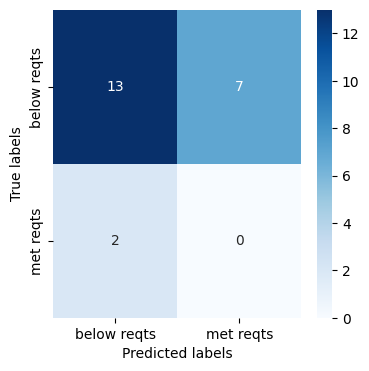

In [68]:
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['below reqts', 'met reqts'], yticklabels=['below reqts', 'met reqts'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [69]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74        20
           1       0.00      0.00      0.00         2

    accuracy                           0.59        22
   macro avg       0.43      0.33      0.37        22
weighted avg       0.79      0.59      0.68        22



## Taking it further

1. Explore [sampling correction methods](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/) for possible over/undersampled groups
2. Explore adding [regularization](https://www.analyticsvidhya.com/blog/2022/08/regularization-in-machine-learning/) options to model training. Regularization is a technique used in machine learning to prevent overfitting by adding a penalty term to the model's loss function, discouraging overly complex models. It helps to find a balance between fitting the training data well and generalizing to unseen data.
3. Explore removing outliers to improve accuracy.
4. Explore if scaling the variables improve performance.